In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
!pip install -q segmentation-models-pytorch
#!pip install -q torchsummary

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.0 MB/s eta 0:00:00


In [3]:
from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if
torch.cuda.is_available() else "cpu")

In [4]:
import os
from google.colab import drive
drive.mount('/drive')

IMAGE_PATH ='/drive/My Drive/Colab Notebooks/aerial_test/dataset/semantic_drone_dataset/original_images/'
MASK_PATH ='/drive/My Drive/Colab Notebooks/aerial_test/dataset/semantic_drone_dataset/label_images_semantic/'

Mounted at /drive


In [5]:
n_classes = 23

def create_df():
  name = []
  for dirname, _, filenames in os.walk(IMAGE_PATH):
    for filename in filenames:
      name.append(filename.split('.')[0])

    return pd.DataFrame({'id': name}, index =
np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  10


In [6]:
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1,
                                      random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15,
                                  random_state=19)

print('Train Size : ', len(X_train))
print('Val Size : ', len(X_val))
print('Test Size : ', len(X_test))

Train Size :  7
Val Size :  2
Test Size :  1


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


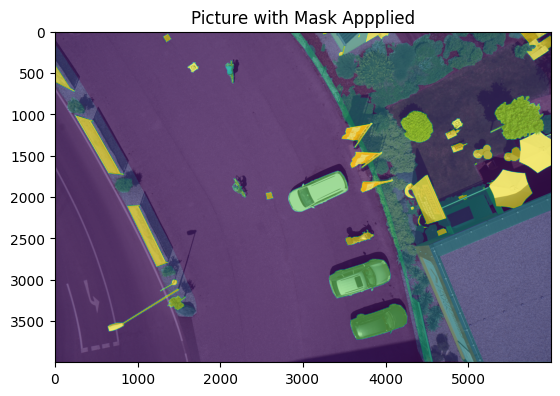

In [7]:
img = Image.open(IMAGE_PATH + df['id'][1] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][1] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)

plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

In [8]:
class DroneDataset(Dataset):
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        if self.patches:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):
        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768)
        img_patches = img_patches.contiguous().view(3, -1, 512, 768)
        img_patches = img_patches.permute(1, 0, 2, 3)

        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)

        return img_patches, mask_patches

In [9]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

t_train = A.Compose([
    A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.GridDistortion(p=0.2),
    A.RandomBrightnessContrast((0, 0.5), (0, 0.5)),
    A.GaussNoise()
])

t_val = A.Compose([
    A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST),
    A.HorizontalFlip(),
    A.GridDistortion(p=0.2)
])

In [10]:
# datasets
train_set = DroneDataset(
    IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False
)
val_set = DroneDataset(
    IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False
)

# dataloader
batch_size = 1

train_loader = DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)
val_loader = DataLoader(
    val_set, batch_size=batch_size, shuffle=True
)

In [11]:
model = smp.Unet(
    'mobilenet_v2',
    encoder_weights='imagenet',
    classes=23,
    activation=None,
    encoder_depth=5,
    decoder_channels=[256, 128, 64, 32, 16]
)

model

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 71.8MB/s]


Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1

In [12]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)

        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())

    return accuracy

In [13]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes):  # loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0:  # no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()
                iou = (intersect + smooth) / (union + smooth)
                iou_per_class.append(iou)

        return np.nanmean(iou_per_class)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [14]:
def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []
    val_acc = []
    train_iou = []
    train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1
    not_improve = 0

    model.to(device)
    fit_time = time.time()

    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0

        # Training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            # Training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()
                image_tiles = image_tiles.view(-1, c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)

            image = image_tiles.to(device)
            mask = mask_tiles.to(device)

            # Forward pass
            output = model(image)
            loss = criterion(output, mask)

            # Evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)

            # Backward pass
            loss.backward()
            optimizer.step()  # Update weights
            optimizer.zero_grad()  # Reset gradients

            # Step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

            running_loss += loss.item()

        # Validation loop
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()
                        image_tiles = image_tiles.view(-1, c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)

                    image = image_tiles.to(device)
                    mask = mask_tiles.to(device)

                    output = model(image)

                    # Evaluation metrics
                    val_iou_score += mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)

                    # Loss calculation
                    loss = criterion(output, mask)
                    test_loss += loss.item()

            # Calculate mean for each batch
            train_losses.append(running_loss / len(train_loader))
            test_losses.append(test_loss / len(val_loader))

            # Check if loss is decreasing
            if min_loss > (test_loss / len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss / len(val_loader))))
                min_loss = (test_loss / len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('Saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score / len(val_loader)))

            # Early stopping
            if (test_loss / len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss / len(val_loader))
                print(f'Loss Not Decrease for {not_improve} times')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stopping Training')
                    break

            # IOU and accuracy
            val_iou.append(val_iou_score / len(val_loader))
            train_iou.append(iou_score / len(train_loader))
            train_acc.append(accuracy / len(train_loader))
            val_acc.append(test_accuracy / len(val_loader))

            # Print results
            print("Epoch:{}/{}..".format(e + 1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss / len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss / len(val_loader)),
                  "Train mIoU: {:.3f}..".format(iou_score / len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score / len(val_loader)),
                  "Train Acc: {:.3f}..".format(accuracy / len(train_loader)),
                  "Val Acc: {:.3f}..".format(test_accuracy / len(val_loader)),
                  "Time: {:.2f}m".format((time.time() - since) / 60))

    history = {
        'train_loss': train_losses,
        'val_loss': test_losses,
        'train_miou': train_iou,
        'val_miou': val_iou,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'lrs': lrs
    }

    print('Total time: {:.2f} m'.format((time.time() - fit_time) / 60))

    return history

In [15]:
max_lr = 1e-2
epoch = 20
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=max_lr, momentum=0.9,
                            weight_decay=weight_decay)

sched = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr, epochs=epoch, steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion,
              optimizer,sched)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 3.200 
Epoch:1/20.. Train Loss: 3.314.. Val Loss: 3.200.. Train mIoU: 0.015.. Val mIoU: 0.013.. Train Acc: 0.036.. Val Acc: 0.036.. Time: 0.44m


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 3.200 >> 2.997 
Epoch:2/20.. Train Loss: 3.109.. Val Loss: 2.997.. Train mIoU: 0.022.. Val mIoU: 0.036.. Train Acc: 0.090.. Val Acc: 0.185.. Time: 0.10m


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 2.997 >> 2.652 
Epoch:3/20.. Train Loss: 2.457.. Val Loss: 2.652.. Train mIoU: 0.050.. Val mIoU: 0.037.. Train Acc: 0.463.. Val Acc: 0.372.. Time: 0.09m


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 2.652 >> 2.509 
Saving model...
Epoch:4/20.. Train Loss: 2.074.. Val Loss: 2.509.. Train mIoU: 0.042.. Val mIoU: 0.038.. Train Acc: 0.490.. Val Acc: 0.373.. Time: 0.10m


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Not Decrease for 1 times
Epoch:5/20.. Train Loss: 1.936.. Val Loss: 2.990.. Train mIoU: 0.050.. Val mIoU: 0.058.. Train Acc: 0.492.. Val Acc: 0.335.. Time: 0.09m


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 2.990 >> 2.314 
Epoch:6/20.. Train Loss: 1.698.. Val Loss: 2.314.. Train mIoU: 0.062.. Val mIoU: 0.066.. Train Acc: 0.511.. Val Acc: 0.411.. Time: 0.09m


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 2.314 >> 1.956 
Epoch:7/20.. Train Loss: 1.640.. Val Loss: 1.956.. Train mIoU: 0.073.. Val mIoU: 0.079.. Train Acc: 0.527.. Val Acc: 0.471.. Time: 0.10m


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 1.956 >> 1.734 
Epoch:8/20.. Train Loss: 1.501.. Val Loss: 1.734.. Train mIoU: 0.089.. Val mIoU: 0.098.. Train Acc: 0.546.. Val Acc: 0.519.. Time: 0.09m


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 1.734 >> 1.559 
Epoch:9/20.. Train Loss: 1.455.. Val Loss: 1.559.. Train mIoU: 0.105.. Val mIoU: 0.118.. Train Acc: 0.555.. Val Acc: 0.592.. Time: 0.10m


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Not Decrease for 2 times
Epoch:10/20.. Train Loss: 1.383.. Val Loss: 1.594.. Train mIoU: 0.118.. Val mIoU: 0.113.. Train Acc: 0.599.. Val Acc: 0.564.. Time: 0.09m


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 1.594 >> 1.464 
Saving model...
Epoch:11/20.. Train Loss: 1.345.. Val Loss: 1.464.. Train mIoU: 0.126.. Val mIoU: 0.115.. Train Acc: 0.617.. Val Acc: 0.588.. Time: 0.09m


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 1.464 >> 1.359 
Epoch:12/20.. Train Loss: 1.202.. Val Loss: 1.359.. Train mIoU: 0.141.. Val mIoU: 0.128.. Train Acc: 0.653.. Val Acc: 0.618.. Time: 0.11m


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 1.359 >> 1.256 
Epoch:13/20.. Train Loss: 1.113.. Val Loss: 1.256.. Train mIoU: 0.163.. Val mIoU: 0.139.. Train Acc: 0.681.. Val Acc: 0.659.. Time: 0.09m


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Not Decrease for 3 times
Epoch:14/20.. Train Loss: 1.108.. Val Loss: 1.294.. Train mIoU: 0.162.. Val mIoU: 0.151.. Train Acc: 0.684.. Val Acc: 0.683.. Time: 0.11m


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Not Decrease for 4 times
Epoch:15/20.. Train Loss: 1.070.. Val Loss: 1.360.. Train mIoU: 0.177.. Val mIoU: 0.139.. Train Acc: 0.702.. Val Acc: 0.643.. Time: 0.09m


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 1.360 >> 1.305 
Epoch:16/20.. Train Loss: 1.010.. Val Loss: 1.305.. Train mIoU: 0.190.. Val mIoU: 0.145.. Train Acc: 0.715.. Val Acc: 0.652.. Time: 0.10m


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Not Decrease for 5 times
Epoch:17/20.. Train Loss: 0.989.. Val Loss: 1.329.. Train mIoU: 0.187.. Val mIoU: 0.132.. Train Acc: 0.723.. Val Acc: 0.627.. Time: 0.11m


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 1.329 >> 1.301 
Epoch:18/20.. Train Loss: 0.979.. Val Loss: 1.301.. Train mIoU: 0.184.. Val mIoU: 0.138.. Train Acc: 0.719.. Val Acc: 0.648.. Time: 0.09m


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Not Decrease for 6 times
Epoch:19/20.. Train Loss: 0.978.. Val Loss: 1.327.. Train mIoU: 0.188.. Val mIoU: 0.139.. Train Acc: 0.717.. Val Acc: 0.641.. Time: 0.10m


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Loss Decreasing.. 1.327 >> 1.204 
Saving model...
Epoch:20/20.. Train Loss: 0.935.. Val Loss: 1.204.. Train mIoU: 0.201.. Val mIoU: 0.156.. Train Acc: 0.732.. Val Acc: 0.694.. Time: 0.09m
Total time: 2.25 m


In [16]:
torch.save(model, 'Unet-Mobilenet.pt')

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

# Function to plot loss
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot(history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()
    plt.show()

# Function to plot mean IoU score
def plot_score(history):
    plt.plot(history['train_miou'], label='train mIoU', marker='*')
    plt.plot(history['val_miou'], label='val mIoU', marker='*')
    plt.title('Score per epoch')
    plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()
    plt.show()

# Function to plot accuracy
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy', marker='*')
    plt.title('Accuracy per epoch')
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.grid()
    plt.show()

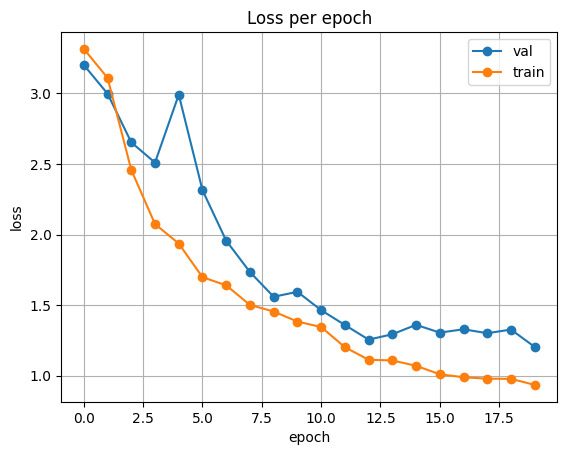

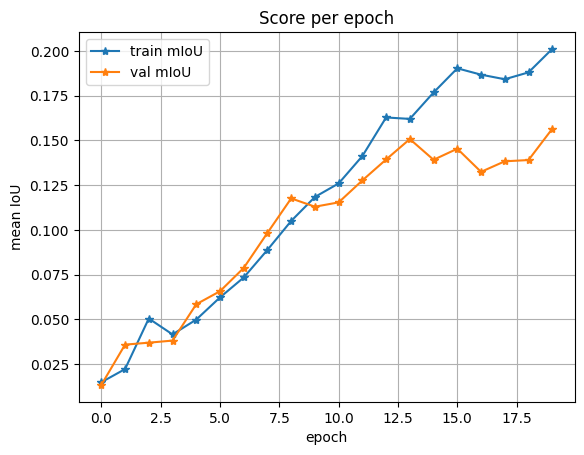

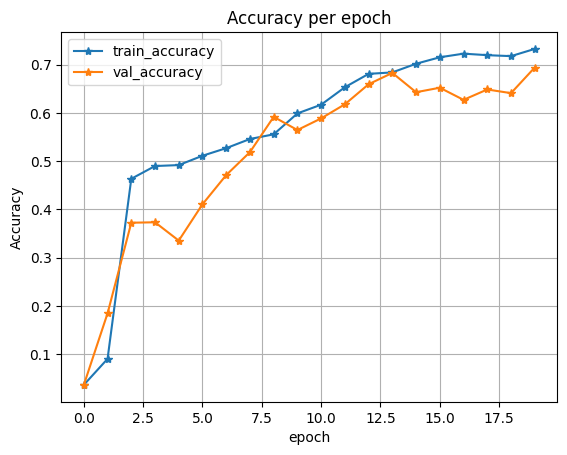

In [18]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [19]:
import cv2
import torch
from torch.utils.data import Dataset
from PIL import Image

class DroneTestDataset(Dataset):
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        else:
            img = Image.fromarray(img)
            mask = torch.from_numpy(mask).long()

        return img, mask


In [20]:
t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)

test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [21]:
import torch
import torchvision.transforms as T
import torch.nn.functional as F

def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], device='cuda'):
    """
    Predict the mask for a given image and compute the mean IoU.

    Parameters:
    - model: The trained model.
    - image: The input image (PIL or numpy array).
    - mask: The ground truth mask (torch tensor).
    - mean: The mean values for normalization (default for ImageNet).
    - std: The std values for normalization (default for ImageNet).
    - device: The device to run the model on ('cuda' or 'cpu').

    Returns:
    - masked: The predicted mask with the highest class value per pixel.
    - score: The mean intersection over union (mIoU) score.
    """
    model.eval()  # Set the model to evaluation mode

    # Define the image transformations
    transform = T.Compose([T.ToTensor(), T.Normalize(mean=mean, std=std)])

    # Apply transformations to the image
    image = transform(image)

    # Move image and model to the specified device
    image = image.to(device)
    model.to(device)

    # Ensure mask is on the same device
    mask = mask.to(device)

    # Add a batch dimension (N, C, H, W)
    image = image.unsqueeze(0)
    mask = mask.unsqueeze(0)

    # Forward pass to get the output
    with torch.no_grad():
        output = model(image)

    # Compute mIoU score
    score = mIoU(output, mask)

    # Get the predicted mask by selecting the class with the highest probability
    masked = torch.argmax(output, dim=1)

    # Move to CPU and remove the batch dimension
    masked = masked.cpu().squeeze(0)

    return masked, score


In [22]:
import torch
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
else:
    print("GPU tidak tersedia!")

Tesla T4


In [23]:
import torch
import torchvision.transforms as T

def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225], device='cuda'):
    model.eval()

    # Transform the image
    transform = T.Compose([T.ToTensor(), T.Normalize(mean=mean, std=std)])
    image = transform(image)

    # Convert mask to Tensor if needed
    if isinstance(mask, np.ndarray):  # Check if mask is a numpy array
        mask = torch.from_numpy(mask).long()  # Convert to Tensor and ensure it's of type long

    # Move image and mask to the specified device
    model.to(device)
    image = image.to(device)
    mask = mask.to(device)

    # Forward pass to get the output
    with torch.no_grad():
        image = image.unsqueeze(0)  # Add batch dimension
        mask = mask.unsqueeze(0)   # Add batch dimension
        output = model(image)
        acc = pixel_accuracy(output, mask)  # Assuming pixel_accuracy is defined elsewhere
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)  # Remove batch dimension and move back to CPU
    return masked, acc

In [24]:
image, mask = test_set[0]  # Ubah angka untuk memilih item berbeda dalam dataset
pred_mask, score = predict_image_mask_pixel(model, image, mask, device='cuda')

In [25]:
import torch
import torchvision.transforms as T

def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225], device='cuda'):
    model.eval()

    # Transform the image
    transform = T.Compose([T.ToTensor(), T.Normalize(mean=mean, std=std)])
    image = transform(image)

    # Convert mask to Tensor if needed
    if isinstance(mask, np.ndarray):  # Check if mask is a numpy array
        mask = torch.from_numpy(mask).long()  # Convert to Tensor and ensure it's of type long

    # Move image and mask to the specified device
    model.to(device)
    image = image.to(device)
    mask = mask.to(device)

    # Forward pass to get the output
    with torch.no_grad():
        image = image.unsqueeze(0)  # Add batch dimension
        mask = mask.unsqueeze(0)   # Add batch dimension
        output = model(image)
        score = mIoU(output, mask)  # Assuming mIoU is defined elsewhere
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)  # Remove batch dimension and move back to CPU

    return masked, score

In [26]:
def pixel_acc(model, test_set):
  accuracy = []
  for i in tqdm(range(len(test_set))):
    img, mask = test_set[i]
    pred_mask, acc = predict_image_mask_pixel(model, img, mask)
    accuracy.append(acc)
  return accuracy
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/1 [00:00<?, ?it/s]

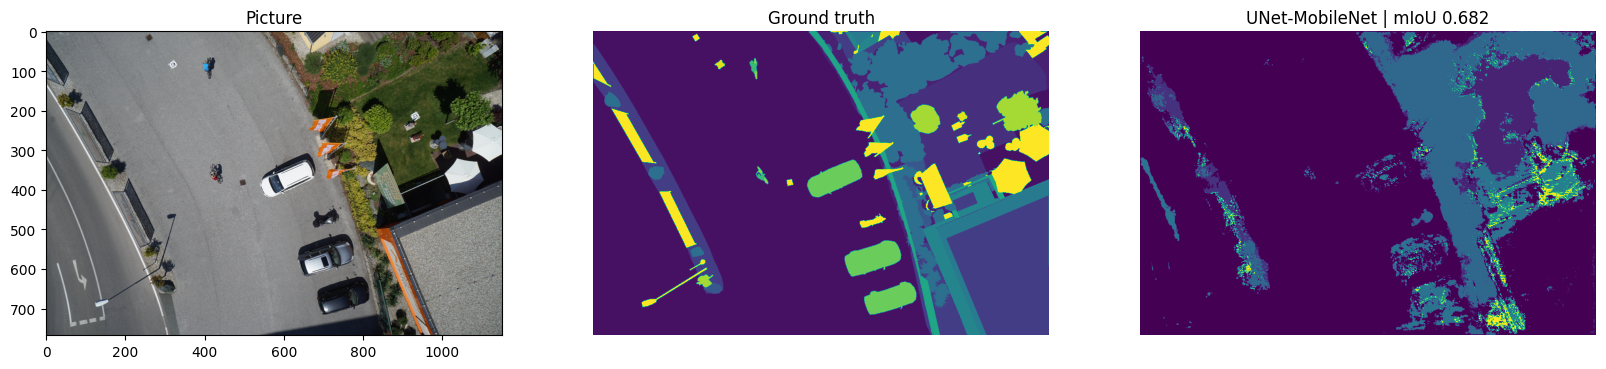

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');
ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()
ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()